Data Exploration

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
#Loading the dataset and fiest check
df = pd.read_csv('creditcard.csv')

print("Shape of dataset:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nInfo:")
print(df.info())

Shape of dataset: (284807, 31)

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 

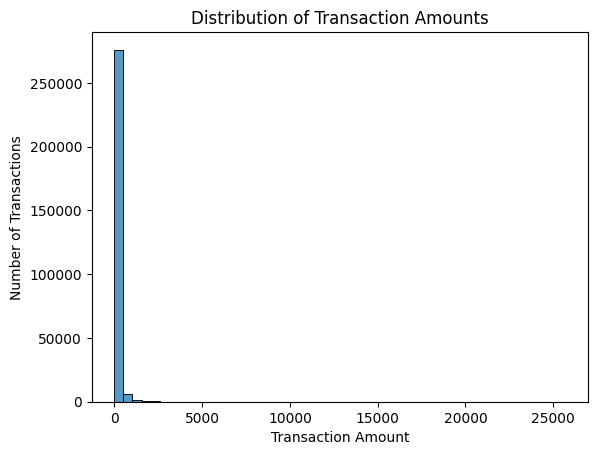

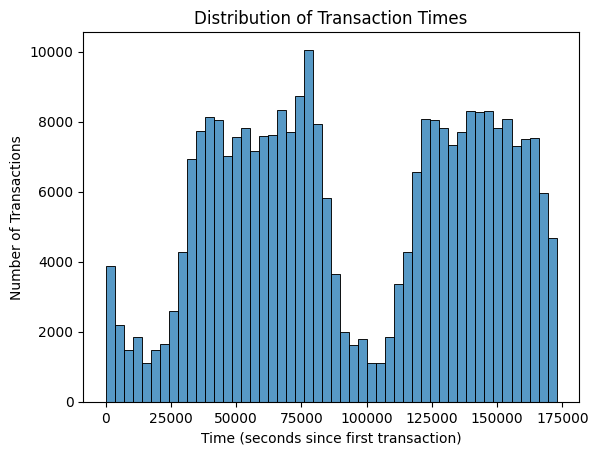

In [24]:
#Exploring the Amount and Time distributions
sns.histplot(df['Amount'], bins=50)
plt.xlabel("Transaction Amount")
plt.ylabel("Number of Transactions")
plt.title("Distribution of Transaction Amounts")
plt.show()

sns.histplot(df['Time'], bins=50)
plt.xlabel("Time (seconds since first transaction)")
plt.ylabel("Number of Transactions")
plt.title("Distribution of Transaction Times")
plt.show()

In [ ]:
#Checking class distribution
#Numericaly
print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


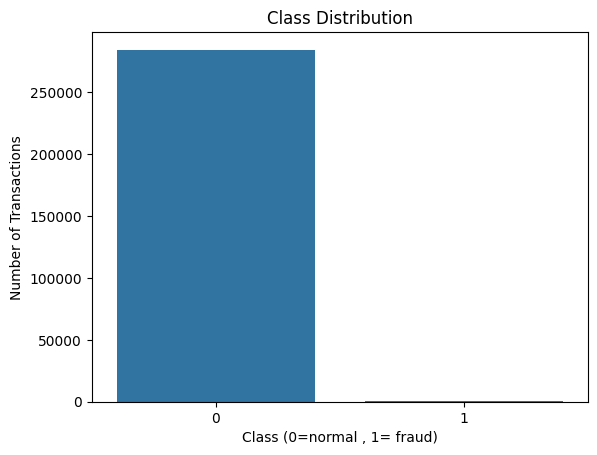

In [29]:
#visualy
sns.countplot(x='Class', data=df)
plt.xlabel("Class (0=normal , 1= fraud)")
plt.ylabel("Number of Transactions")
plt.title("Class Distribution")
plt.show()

Preprocessing

In [33]:
#Scaling numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


Unsupervised Modeling

In [34]:
#Isolation Forest
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.0017,
    random_state=42
)

In [35]:
#Fit the model on all features except the Class label
Features = df.drop('Class', axis=1)
iso_forest.fit(Features)

,n_estimators,100
,max_samples,'auto'
,contamination,0.0017
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [36]:
#Predicting anomalies
df['anomaly'] = iso_forest.predict(Features)

In [37]:
df['anomaly_converted'] = df['anomaly'].map({1:0 , -1:1})

In [38]:
#Evaluation metrics
from sklearn.metrics import classification_report , confusion_matrix

print(confusion_matrix(df['Class'], df['anomaly_converted']))
print(classification_report(df['Class'], df['anomaly_converted']))

[[283955    360]
 [   367    125]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.26      0.25      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807



The model is very good at identifying normal transactions.
But it struggles to detect fraud, missing most of them (low recall).
This is normal with anomaly detection, because the fraud cases are extremely rare and hard to catch.
Now I can either try another unsupervised model or to try supervised ML, but we will continue with unsupervised ML.

In [39]:
#One-Class SVM Implementation
X = df.drop(columns=['Class'])
y_true = df['Class']

In [40]:
# Subsample for training to keep OCSVM practical
X_train = X.sample(n=60000, random_state=42)

In [45]:
#Instantiate and fit One-Class SVM
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(
    kernel='rbf',   
    gamma='scale',  
    nu=0.01,        
    shrinking=True, 
    tol=1e-3        
)

# Fit on the (unsupervised) training subset
ocsvm.fit(X_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,nu,0.01
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [46]:
# Predict on ALL rows
y_pred_raw = ocsvm.predict(X)              
y_pred = np.where(y_pred_raw == -1, 1, 0)

In [47]:
#Evaluate against hidden labels
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[280273   4042]
 [   156    336]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.08      0.68      0.14       492

    accuracy                           0.99    284807
   macro avg       0.54      0.83      0.57    284807
weighted avg       1.00      0.99      0.99    284807



Good: The model detects more frauds than Isolation Forest.
Bad: It also flags many normal transactions as fraud (false positives).
This is actually common with anomaly detection: you either
 -catch more fraud (high recall) but annoy customers with false alarms, OR
 -be strict (high precision) but miss fraud.